In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import matplotlib.pyplot as plt
!pip install -q tensorflow==2.0.0-beta1
import tensorflow as tf
import numpy as np
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0-beta1
Eager execution: True


In [2]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)
#print("Local copy of the dataset file: {}".format(train_dataset_fp))
#!head -n5 {train_dataset_fp}
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

#print("Features: {}".format(feature_names))
#print("Label: {}".format(label_name))
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

features, labels = next(iter(train_dataset))
"""
print(features)
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()
"""
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels
train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))
#print(features[:5])
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])
predictions = model(features)
#predictions[:5]
tf.nn.softmax(predictions[:5])
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))


W0627 19:33:43.762685 140572835215232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/experimental/ops/readers.py:498: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [0 2 0 1 0 2 1 1 0 0 2 0 0 1 1 2 0 0 1 0 0 1 1 2 1 2 0 2 1 1 2 2]


Let's first look at the performence of a 

Loss test: 0.2469310462474823
Epoch 000: Loss: 0.330, Accuracy: 87.500%
Epoch 050: Loss: 0.057, Accuracy: 98.333%
Epoch 100: Loss: 0.047, Accuracy: 98.333%
Epoch 150: Loss: 0.070, Accuracy: 98.333%
Epoch 200: Loss: 0.055, Accuracy: 97.500%


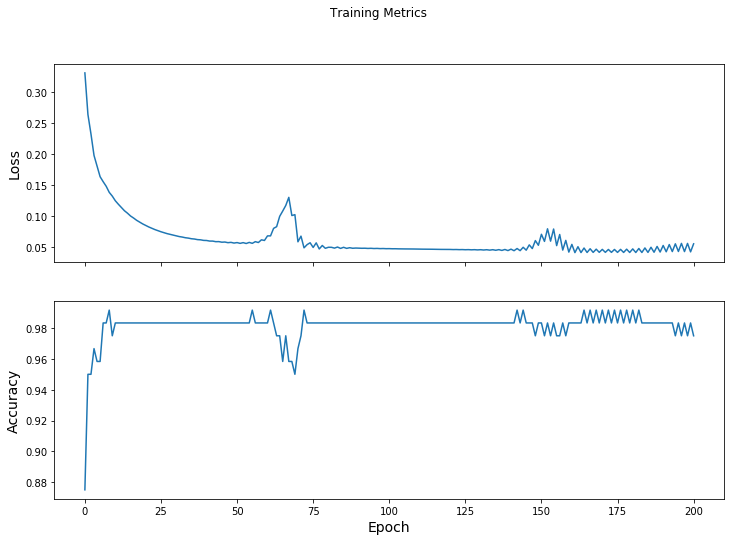

In [63]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y):
  y_ = model(x)
  return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

Our design of loss function is the distance between the distribution of errors and the continuous target distribution which can be Gaussian or Delta. Given that Delta is meaningless beyound integral, andt its integral, which is a step function, is dicontinuous. Let's consider Normal distribution. Normal distribution is much nicer. Actually, its density is infinitely differetiable with a very nice form:

![alt text](http://i64.tinypic.com/2461h5y.png)    where ![alt text](http://i66.tinypic.com/j6lruh.jpg) is the density function for ![alt text](http://i68.tinypic.com/k1yp9i.png)

-------------------------------------------------------------------------------------------------------
Let's give up on calculating the differenation of Normal pdf.


Thanks for [Shangkun](https://github.com/polossk)'s help, I will use kernel method here, more specifically, MMD ([Maximum Mean Divergence](https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution)), to calculate the similarity between the distribution of the sample, and the target distribution. This method uses large size of samples to approximiate the target distribution. Compared to methods such as fitting parametric distribution, curve fitting,  using MMD here has several advantage:


*   Allows samples of different size
*   differentiable
*   easy to calculate
*   no assumption for distribution or polynomial curve
*   no hyper-parameter, flexible for different batch size and good for reproducibility
*   avoid dealing with overfitting

The specific kernel function I used here is:

![alt text](http://i63.tinypic.com/25he81f.png)

The partial derivative of MMD w.r.t  xi is:


![alt text](http://i67.tinypic.com/34e9sig.png)


To illustate this method makes sense, an example is show below, you can see the distributions of `b` and `c` are more similar than those of `a` and `c`, correspondingly, you can see the MMD of  `b` and `c` is smaller than that of `a` and `c`.

a:[-40, -40, -35, 40, 35, 40] b:[-10, -5, -15, -20, 2, 5, 10] c:[-1, -6, -4, -1, 0, 2, 4, 1, 3, 2, 0, 8] 
MMD1d(a, c):2138418.7778.   MMD1d(b, c):12747.4853


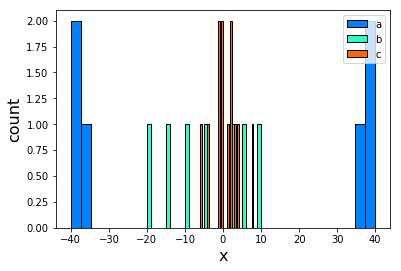

In [3]:
from matplotlib.patches import Rectangle

def MMD1d(x1, x2): # a and b are lists of aribiturary lengths
  dis = sum([x**2 for x in x1])/len(x1) - sum([x**2 for x in x2])/len(x2)
  return dis**2

a, b, c = [-40, -40, -35, 40, 35, 40], [-10, -5, -15, -20,2, 5, 10], [-1,-6,-4,-1, 0, 2, 4, 1, 3, 2, 0, 8]
print(f'a:{a} b:{b} c:{c}', '\nMMD1d(a, c):%.4f.   MMD1d(b, c):%8.4f'%(MMD1d(a, c),MMD1d(b, c)))

a_N, a_bins, a_patches = plt.hist(np.array(a), 30, ec="k")
b_N, b_bins, b_patches = plt.hist(np.array(b), 30, ec="k")
c_N, c_bins, c_patches = plt.hist(np.array(c), 30, ec="k")
cmap = plt.get_cmap('jet')
for i in range(30):
  a_patches[i].set_facecolor(cmap(0.25))
for i in range(30):
  b_patches[i].set_facecolor(cmap(0.4))
for i in range(30):
  c_patches[i].set_facecolor(cmap(0.8))
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [cmap(0.25),cmap(0.4), cmap(0.8)]]
lab= ["a","b", "c"]
plt.legend(handles, lab)
plt.xlabel("x", fontsize=16)  
plt.ylabel("count", fontsize=16)
plt.show()

Just for record, my original loss function is designed as below, the grads will return a list of 6 `None`s for 3 layers model. The reason is that the original loss function is not differentiable. 

In [81]:
import scipy.stats

def get_distance_between_samples_and_distribution(errors, if_plot = 1, n_bins = 5):
  def get_middle(x):
    xMid = np.zeros(x.shape[0]//2)
    for i in range(xMid.shape[0]):
      xMid[i] = 0.5*(x[2*i]+x[2*i+1])
    return xMid

  bins, edges = np.histogram(errors, n_bins, normed=1)
  left,right = edges[:-1],edges[1:]
  X = np.array([left,right]).T.flatten()
  Y = np.array([bins,bins]).T.flatten()
  X_middle = get_middle(X)
  Y_middle = get_middle(Y)
  distance = []
  for i in range(X_middle.shape[0]):
    dis = np.square(scipy.stats.norm.pdf(X_middle[i])- Y_middle[i])
    distance.append(dis)
  distance2 = np.power(distance, 2)
  
  return sum(distance2)/len(distance2)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y):
  y_ = model(x)
  losses = []
  # y_.shape is (batch_size, 3)
  for i in range(y.shape[0]):
    loss = loss_object(y_true=y[i], y_pred=y_[i])
    losses.append(loss)
  dis = get_distance_between_samples_and_distribution(losses, if_plot = 0)
  return tf.convert_to_tensor(dis, dtype=np.float32)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

loss_value, grads = grad(model, features, labels)
print("loss_value:",loss_value)
print("type(loss_value):", type(loss_value))
print("\ngrads:", grads)

loss_value: tf.Tensor(0.124988295, shape=(), dtype=float32)
type(loss_value): <class 'tensorflow.python.framework.ops.EagerTensor'>

grads: [None, None, None, None, None, None]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  # Remove the CWD from sys.path while we load stuff.


As written before, the MMD function is differentiable and therefore can be used to train the model.

In [4]:
def get_MMD_norm(errors, sigma=0.1): # sigma is the standard deviation of our target distribution, it keeps updating to smaller value during training
  x2 = np.random.normal(0, sigma, 100)
  loss = MMD1d(errors, x2)
  return loss

def loss(model, x, y, sigma=0.1):
  y_ = model(x) # y_.shape is (batch_size, 3) for Iris dataset
  losses = []
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  for i in range(y.shape[0]):
    loss = loss_object(y_true=y[i], y_pred=y_[i])
    losses.append(loss)
  loss = get_MMD_norm(losses)
  return tf.convert_to_tensor(loss, dtype=np.float32)

def grad(model, inputs, targets, sigma=0.1):
  with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    loss_value = loss(model, inputs, targets, sigma=0.1)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

loss_value, grads = grad(model, features, labels)
print("loss_value:",loss_value)
print("type(loss_value):", type(loss_value))
print("\ngrads:", grads)

W0627 19:34:12.521479 140572835215232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


loss_value: tf.Tensor(5.2018685, shape=(), dtype=float32)
type(loss_value): <class 'tensorflow.python.framework.ops.EagerTensor'>

grads: [<tf.Tensor: id=3407, shape=(4, 10), dtype=float32, numpy=
array([[ 0.0000000e+00, -5.5058842e+00, -2.2550030e+00,  9.0526266e+00,
         0.0000000e+00,  6.7714036e-02,  6.0171599e+00,  0.0000000e+00,
        -5.4114860e-01,  1.7458668e+01],
       [ 0.0000000e+00, -2.4942534e+00, -1.2337697e+00,  4.0624032e+00,
         0.0000000e+00,  4.4814423e-02,  2.7173367e+00,  0.0000000e+00,
        -1.1339052e-01,  7.5628257e+00],
       [ 0.0000000e+00, -4.3045316e+00, -8.3117121e-01,  7.0900888e+00,
         0.0000000e+00,  1.5052046e-02,  4.5160708e+00,  0.0000000e+00,
        -1.3855304e+00,  1.4965874e+01],
       [ 0.0000000e+00, -1.4712715e+00, -1.7763006e-02,  2.3849266e+00,
         0.0000000e+00,  2.4014930e-03,  1.4336034e+00,  0.0000000e+00,
        -8.1996495e-01,  5.4340229e+00]], dtype=float32)>, <tf.Tensor: id=3406, shape=(10,), dtype=float

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 5.201868534088135
Step: 1,         Loss: 1.9709848165512085


In [84]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 200

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 2.565, Accuracy: 30.000%
Epoch 050: Loss: 0.032, Accuracy: 96.667%
Epoch 100: Loss: 0.008, Accuracy: 98.333%
Epoch 150: Loss: 0.004, Accuracy: 98.333%


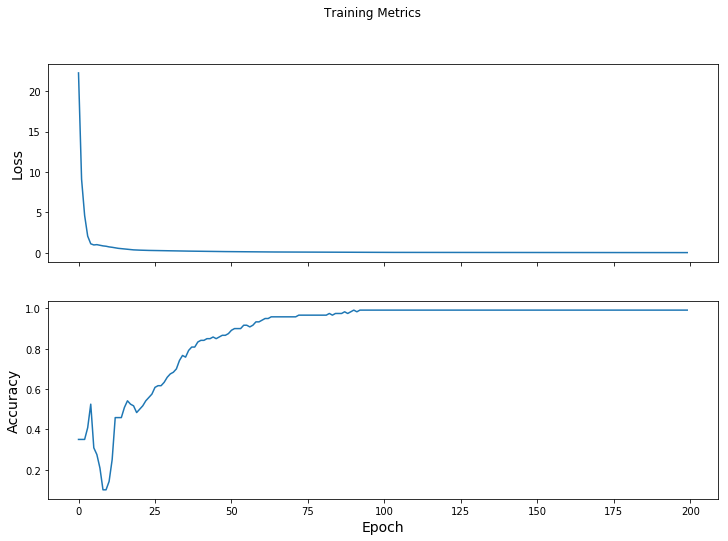

In [62]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

To better leverage the design of loss function, I will use callbacks to detect the learning progress, once the loss stopped decreasing for 10 epochs, instead of early stopping, I will shrink the standard deviation of the target distribution by half. Now, let's write the callbacks for tracking loss history.

In [0]:
def plot_bar(errors, num):
    plt.hist(errors, bins = 20)
    plt.xlabel("Prediction Error [MPG]")
    title = "epoch:" + str(num)
    plt.title(title)
    _ = plt.ylabel("Count")
    plt.show()
    plt.savefig(title)

sigma: 0.1
Epoch 000: Loss: 1.134, Accuracy: 53.333%


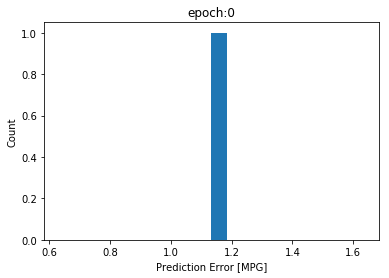

sigma: 0.1
Epoch 050: Loss: 0.019, Accuracy: 97.500%


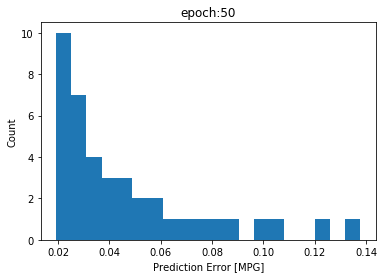

sigma: 0.1
Epoch 100: Loss: 0.008, Accuracy: 99.167%


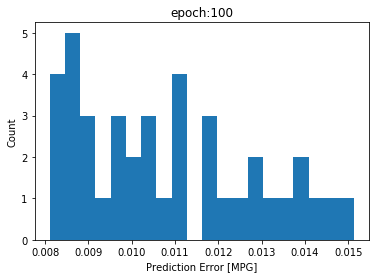

sigma: 0.1
Epoch 150: Loss: 0.006, Accuracy: 99.167%


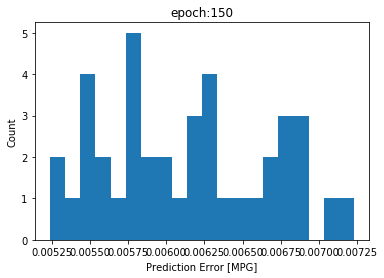

sigma: 0.05
Epoch 200: Loss: 0.004, Accuracy: 99.167%


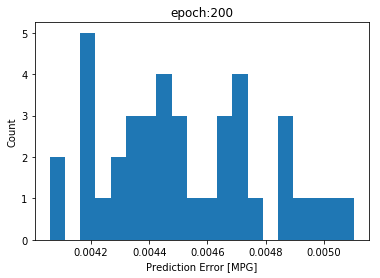

sigma: 0.025
Epoch 250: Loss: 0.003, Accuracy: 98.333%


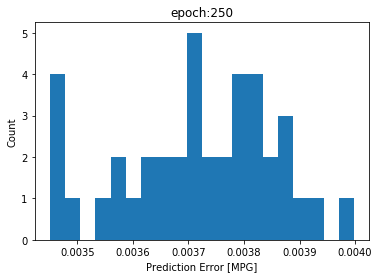

sigma: 0.0125
Epoch 300: Loss: 0.082, Accuracy: 70.833%


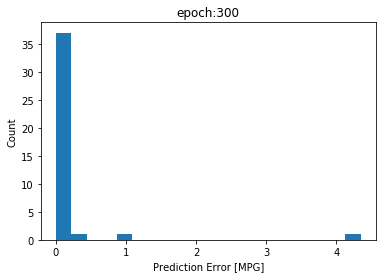

sigma: 0.00625
Epoch 350: Loss: 0.039, Accuracy: 95.833%


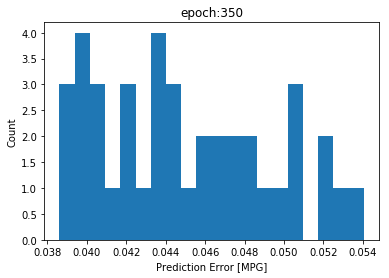

sigma: 0.00625
Epoch 400: Loss: 0.029, Accuracy: 96.667%


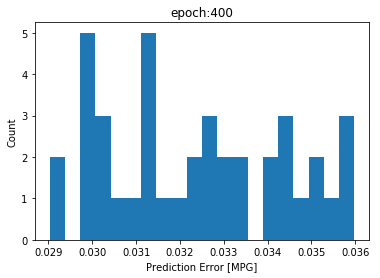

sigma: 0.003125
Epoch 450: Loss: 0.022, Accuracy: 98.333%


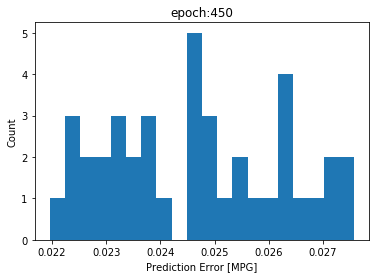

<Figure size 432x288 with 0 Axes>

In [7]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 500
patience_n = 25
patience = patience_n
sigma=0.1
for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  if patience <= 0: 
    sigma/=2
    patience = patience_n
  # Training loop - using batches of 32
  for x, y in train_dataset:
    loss_value, grads = grad(model, x, y, sigma)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch>1 and train_loss_results[-1].numpy() > train_loss_results[-2].numpy():
    patience -=1

  if epoch % 50 == 0:
    print("sigma:", sigma)
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
    plot_bar(train_loss_results[-40:], epoch)

In [71]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

1.5

In [37]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [0]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

In [0]:
tf.stack([y,prediction],axis=1)

In [0]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))